# [FinRL: 强化学习在量化金融中的应用](https://github.com/QYQSDTC/FinRL)
*注：本文不构成任何投资建议，入市有风险，投资需谨慎。*
## 小组成员
钱以骞 物理学院 D202180035

马瑞廷 计算机学院

张文涛 计算机学院

丛宇恒 计算机学院

## 目标
- 了解强化学习在量化金融中的应用
- 通过强化学习的方法，实现一个简单的量化交易策略
- 比较不同的强化学习算法在量化金融中的表现
  - 钱以骞：DDPG
  - 张文涛：SAC
  - 丛宇恒：A2C
  - 马瑞妍：PPO

## 用到的Package
- [FinRL](https://github.com/AI4Finance-Foundation/FinRL): 一个强化学习在量化金融中的应用的开源库
- [Tushare](https://tushare.pro/): 一个免费的金融数据接口
- [Quantopian Pyfolio](https://github.com/quantopian/pyfolio): 一个自动化回测工具包

### Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 100, 'display.min_rows', 50,'display.max_columns', 100)
from IPython import display
import tushare as ts
display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.tushare import Tushare, ReturnPlotter
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
from agents.stablebaselines3_models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import datetime
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


## Create folders

In [2]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )

## Data preparation: download, cleansing and feature engineering
我们用Tushare获取了A股市场近10年的数据 (2012/01/01 -- 2022/09/28)，包括开盘价、收盘价、最高价、最低价、成交量、成交额、涨跌幅等信息。我们用这些数据来训练我们的强化学习模型。
### 个股的选择
因为本项目的主要目的是研究强化学习在量化金融中的应用，所以个股的选择我们就简单的从上证50中选取了5只权重股，包括：贵州茅台，万华化学，中国平安，中国中免，恒瑞医药。

如果想要更好的收益，可以用量化因子选股或者其它的一些量化方法，但是这不在本项目的讨论范围内。

In [3]:
train_start_date='2012-01-01'
train_stop_date='2020-01-01'
trade_start_date='2020-01-01'
trade_stop_date='2022-09-30'

# token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'
token='829a1fbce8eb0e34f05ab19906d0e08227c6f64261a81272aa078ccd'

pro = ts.pro_api(token)

In [4]:
pro.index_weight(index_code = '000016.SH', start_date = '20220901')

,index_code,con_code,trade_date,weight
0,000016.SH,601012.SH,20220930,4.460
1,000016.SH,600745.SH,20220930,0.547
2,000016.SH,600104.SH,20220930,1.026
3,000016.SH,600690.SH,20220930,1.440
4,000016.SH,601088.SH,20220930,1.602
5,000016.SH,600028.SH,20220930,0.881
6,000016.SH,600809.SH,20220930,2.270
7,000016.SH,601995.SH,20220930,0.309
8,000016.SH,600519.SH,20220930,18.058
9,000016.SH,601919.SH,20220930,1.071


In [5]:
# ticket_list=['600519.SH', '600309.SH', '601318.SH', '601888.SH', '600276.SH']
# take 上证50成分股
ticker_list = pro.index_weight(index_code = '000016.SH', start_date = '20220901').con_code.unique().tolist()
ticker_list
print(f'Number of stocks: {len(ticker_list)}, stocks: {ticker_list}')

Number of stocks: 50, stocks: ['601012.SH', '600745.SH', '600104.SH', '600690.SH', '601088.SH', '600028.SH', '600809.SH', '601995.SH', '600519.SH', '601919.SH', '601166.SH', '601668.SH', '601601.SH', '600436.SH', '601066.SH', '601318.SH', '600030.SH', '600588.SH', '600276.SH', '600438.SH', '600570.SH', '603501.SH', '600837.SH', '603288.SH', '603986.SH', '601688.SH', '600036.SH', '601857.SH', '600196.SH', '603799.SH', '600887.SH', '600111.SH', '600031.SH', '600048.SH', '600905.SH', '601398.SH', '601633.SH', '601288.SH', '600893.SH', '601628.SH', '600010.SH', '600585.SH', '600900.SH', '603259.SH', '601899.SH', '601888.SH', '600346.SH', '601728.SH', '601211.SH', '600309.SH']


In [4]:
# download and clean
ts_processor = Tushare(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=trade_stop_date,
                                   time_interval="1d",
                                   token=token)

In [7]:
ts_processor.download_data(ticker_list=ticker_list)
ts_processor.dataframe.to_csv('./datasets/A_stock.csv')

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Shape of DataFrame:  (113660, 8)


In [8]:
df = pd.read_csv('./datasets/A_stock.csv')
len(df.tic.unique())

50

### Clean Data

In [9]:
df = df.sort_values(["date", "tic"], ignore_index=True)
df.index = df.date.factorize()[0]
merged_closes = df.pivot_table(index="date", columns="tic", values="close")
merged_closes

tic,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600346.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600745.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,600905.SH,601012.SH,601066.SH,601088.SH,601166.SH,601211.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601728.SH,601857.SH,601888.SH,601899.SH,601919.SH,601995.SH,603259.SH,603288.SH,603501.SH,603799.SH,603986.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-04,4.15,7.36,9.56,12.09,11.67,10.05,14.16,37.61,8.34,28.45,12.50,7.07,73.03,4.85,185.27,11.50,15.28,16.90,8.78,5.79,57.79,7.12,19.73,13.29,6.29,NaN,NaN,NaN,24.60,12.50,NaN,2.60,33.90,4.22,19.04,17.46,11.87,2.86,7.62,NaN,9.75,25.59,3.81,4.50,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,4.10,7.42,9.29,12.06,11.91,9.80,14.39,35.64,8.25,27.00,12.10,6.86,70.50,4.66,183.15,10.70,14.92,16.48,8.73,5.54,55.04,7.08,19.33,12.66,6.24,NaN,NaN,NaN,24.29,12.71,NaN,2.65,33.93,4.25,19.12,16.58,12.10,2.87,7.36,NaN,9.80,24.17,3.78,4.30,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,4.34,7.48,9.39,12.06,11.99,9.71,14.20,36.32,8.08,26.55,12.06,6.40,70.08,4.72,186.64,10.67,14.72,16.23,8.79,5.76,53.69,7.30,19.66,12.95,6.22,NaN,NaN,NaN,24.27,12.79,NaN,2.66,33.85,4.28,19.23,16.73,11.81,2.87,7.49,NaN,9.96,23.61,3.80,4.32,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,4.48,7.75,9.75,12.55,12.38,10.17,14.90,39.02,8.34,27.40,12.47,6.64,70.10,4.89,188.01,11.00,15.55,16.58,9.07,6.00,54.59,7.62,20.13,13.39,6.29,NaN,NaN,NaN,26.01,13.04,NaN,2.68,34.73,4.31,19.73,17.28,12.26,2.93,7.79,NaN,10.03,24.41,3.93,4.47,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,4.54,7.79,10.12,13.31,12.56,10.35,15.25,40.39,8.66,27.75,13.21,7.02,72.00,5.10,194.48,11.34,16.59,17.02,9.42,6.21,57.00,7.93,20.58,13.79,6.40,NaN,NaN,NaN,26.76,13.15,NaN,2.69,36.29,4.35,20.40,18.23,12.46,3.08,8.13,NaN,10.12,25.60,4.12,4.68,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-11,4.79,7.70,10.08,13.13,12.49,10.31,15.10,42.63,8.63,27.70,13.25,7.14,72.85,5.06,189.68,11.25,16.38,17.79,9.26,6.13,57.67,7.85,20.61,13.72,6.38,NaN,NaN,NaN,26.49,13.02,NaN,2.67,35.83,4.35,20.20,18.22,12.41,3.04,8.00,NaN,10.04,25.95,4.16,4.63,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-12,4.77,7.66,10.03,13.22,12.62,10.39,15.29,43.46,8.58,27.37,13.31,7.07,73.99,5.03,190.35,11.05,16.51,17.14,9.23,6.28,55.89,7.85,20.50,14.10,6.41,NaN,NaN,NaN,26.49,13.30,NaN,2.65,36.37,4.33,20.03,18.30,12.65,3.04,7.93,NaN,10.06,25.47,4.15,4.69,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,4.69,7.62,9.80,12.92,12.49,10.28,14.69,44.96,8.31,26.80,12.83,6.81,71.73,4.87,188.69,10.49,15.75,16.51,8.83,6.50,53.98,7.71,20.22,13.26,6.35,NaN,NaN,NaN,26.33,13.28,NaN,2.65,36.03,4.34,19.95,17.89,12.26,3.01,7.87,NaN,10.20,24.93,4.06,4.48,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,4.32,7.54,9.83,13.06,12.39,9.93,14.39,41.08,8.17,26.00,12.50,6.52,69.15,4.76,177.41,10.30,15.28,16.03,8.70,5.91,50.77,7.64,19.01,12.89,6.36,NaN,NaN,NaN,26.02,13.32,NaN,NaN,35.59,4.31,19.85,17.81,NaN,2.98,7.73,NaN,10.09,23.59,3.96,4.38,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_length = len(merged_closes)
merged_closes.dropna(axis=1, thresh = int(0.9*data_length), inplace=True)
merged_closes

tic,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,601012.SH,601088.SH,601166.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601857.SH,601888.SH,601899.SH,601919.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-04,4.15,7.36,9.56,12.09,11.67,10.05,14.16,37.61,8.34,28.45,12.50,73.03,4.85,185.27,11.50,15.28,16.90,8.78,57.79,7.12,19.73,13.29,6.29,NaN,24.60,12.50,2.60,33.90,4.22,19.04,17.46,11.87,2.86,7.62,9.75,25.59,3.81,4.50
2012-01-05,4.10,7.42,9.29,12.06,11.91,9.80,14.39,35.64,8.25,27.00,12.10,70.50,4.66,183.15,10.70,14.92,16.48,8.73,55.04,7.08,19.33,12.66,6.24,NaN,24.29,12.71,2.65,33.93,4.25,19.12,16.58,12.10,2.87,7.36,9.80,24.17,3.78,4.30
2012-01-06,4.34,7.48,9.39,12.06,11.99,9.71,14.20,36.32,8.08,26.55,12.06,70.08,4.72,186.64,10.67,14.72,16.23,8.79,53.69,7.30,19.66,12.95,6.22,NaN,24.27,12.79,2.66,33.85,4.28,19.23,16.73,11.81,2.87,7.49,9.96,23.61,3.80,4.32
2012-01-09,4.48,7.75,9.75,12.55,12.38,10.17,14.90,39.02,8.34,27.40,12.47,70.10,4.89,188.01,11.00,15.55,16.58,9.07,54.59,7.62,20.13,13.39,6.29,NaN,26.01,13.04,2.68,34.73,4.31,19.73,17.28,12.26,2.93,7.79,10.03,24.41,3.93,4.47
2012-01-10,4.54,7.79,10.12,13.31,12.56,10.35,15.25,40.39,8.66,27.75,13.21,72.00,5.10,194.48,11.34,16.59,17.02,9.42,57.00,7.93,20.58,13.79,6.40,NaN,26.76,13.15,2.69,36.29,4.35,20.40,18.23,12.46,3.08,8.13,10.12,25.60,4.12,4.68
2012-01-11,4.79,7.70,10.08,13.13,12.49,10.31,15.10,42.63,8.63,27.70,13.25,72.85,5.06,189.68,11.25,16.38,17.79,9.26,57.67,7.85,20.61,13.72,6.38,NaN,26.49,13.02,2.67,35.83,4.35,20.20,18.22,12.41,3.04,8.00,10.04,25.95,4.16,4.63
2012-01-12,4.77,7.66,10.03,13.22,12.62,10.39,15.29,43.46,8.58,27.37,13.31,73.99,5.03,190.35,11.05,16.51,17.14,9.23,55.89,7.85,20.50,14.10,6.41,NaN,26.49,13.30,2.65,36.37,4.33,20.03,18.30,12.65,3.04,7.93,10.06,25.47,4.15,4.69
2012-01-13,4.69,7.62,9.80,12.92,12.49,10.28,14.69,44.96,8.31,26.80,12.83,71.73,4.87,188.69,10.49,15.75,16.51,8.83,53.98,7.71,20.22,13.26,6.35,NaN,26.33,13.28,2.65,36.03,4.34,19.95,17.89,12.26,3.01,7.87,10.20,24.93,4.06,4.48
2012-01-16,4.32,7.54,9.83,13.06,12.39,9.93,14.39,41.08,8.17,26.00,12.50,69.15,4.76,177.41,10.30,15.28,16.03,8.70,50.77,7.64,19.01,12.89,6.36,NaN,26.02,13.32,NaN,35.59,4.31,19.85,17.81,NaN,2.98,7.73,10.09,23.59,3.96,4.38


In [11]:
# select the stocks with missing data less than 10%
tics = merged_closes.columns
df = df[df.tic.isin(tics)]
df

,Unnamed: 0,tic,date,open,high,low,close,volume,day
0,0,600010.SH,2012-01-04,4.15,4.28,4.09,4.15,672559.53,2
0,1,600028.SH,2012-01-04,7.28,7.44,7.27,7.36,528181.38,2
0,2,600030.SH,2012-01-04,9.79,9.85,9.56,9.56,354005.33,2
0,3,600031.SH,2012-01-04,12.61,12.73,12.07,12.09,235312.56,2
0,4,600036.SH,2012-01-04,11.95,12.10,11.63,11.67,522606.17,2
0,5,600048.SH,2012-01-04,10.01,10.30,9.91,10.05,341555.93,2
0,6,600104.SH,2012-01-04,14.28,14.53,13.92,14.16,272418.21,2
0,7,600111.SH,2012-01-04,37.90,38.20,37.51,37.61,160533.19,2
0,8,600196.SH,2012-01-04,8.60,8.68,8.30,8.34,36465.88,2
0,9,600276.SH,2012-01-04,29.50,29.75,28.40,28.45,11847.13,2


In [12]:
# back fill missing data then front fill
df = df.fillna(method = 'bfill').fillna(method = 'ffill')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,tic,date,open,high,low,close,volume,day
0,600010.SH,2012-01-04,4.15,4.28,4.09,4.15,672559.53,2
0,600028.SH,2012-01-04,7.28,7.44,7.27,7.36,528181.38,2
0,600030.SH,2012-01-04,9.79,9.85,9.56,9.56,354005.33,2
0,600031.SH,2012-01-04,12.61,12.73,12.07,12.09,235312.56,2
0,600036.SH,2012-01-04,11.95,12.10,11.63,11.67,522606.17,2
0,600048.SH,2012-01-04,10.01,10.30,9.91,10.05,341555.93,2
0,600104.SH,2012-01-04,14.28,14.53,13.92,14.16,272418.21,2
0,600111.SH,2012-01-04,37.90,38.20,37.51,37.61,160533.19,2
0,600196.SH,2012-01-04,8.60,8.68,8.30,8.34,36465.88,2
0,600276.SH,2012-01-04,29.50,29.75,28.40,28.45,11847.13,2


In [13]:
# add_technical_indicator
ts_processor.dataframe = df
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.clean_data()
ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (99142, 17)


,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.267500,4.267500
1,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.502500,7.502500
2,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.497500,9.497500
3,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.190000,12.190000
4,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.987500,11.987500
5,600048.SH,2012-01-09,3.0,9.66,10.21,9.56,10.17,469341.00,0.0,0.004945,10.360324,9.504676,58.928190,40.000000,3.558436,9.932500,9.932500
6,600104.SH,2012-01-09,3.0,14.21,14.95,14.06,14.90,356606.32,0.0,0.023904,15.092770,13.732230,83.281583,131.360947,43.366115,14.412500,14.412500
7,600111.SH,2012-01-09,3.0,36.33,39.40,35.78,39.02,263676.19,0.0,0.067193,40.131340,34.163660,64.586597,77.199282,7.583484,37.147500,37.147500
8,600196.SH,2012-01-09,3.0,8.10,8.35,8.04,8.34,62208.12,0.0,-0.000915,8.497653,8.007347,51.137481,-14.245014,49.001351,8.252500,8.252500
9,600276.SH,2012-01-09,3.0,26.65,27.50,25.60,27.40,43085.35,0.0,-0.033764,28.972755,25.727245,32.197647,-56.144438,100.000000,27.350000,27.350000


In [14]:
ts_processor.dataframe.to_csv('./datasets/A_stock_processed.csv')

### Split traning dataset

In [5]:
ts_processor.dataframe = pd.read_csv('./datasets/A_stock_processed.csv', index_col=[0])
ts_processor.dataframe

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.267500,4.267500
1,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.502500,7.502500
2,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.497500,9.497500
3,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.190000,12.190000
4,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.987500,11.987500
5,600048.SH,2012-01-09,3.0,9.66,10.21,9.56,10.17,469341.00,0.0,0.004945,10.360324,9.504676,58.928190,40.000000,3.558436,9.932500,9.932500
6,600104.SH,2012-01-09,3.0,14.21,14.95,14.06,14.90,356606.32,0.0,0.023904,15.092770,13.732230,83.281583,131.360947,43.366115,14.412500,14.412500
7,600111.SH,2012-01-09,3.0,36.33,39.40,35.78,39.02,263676.19,0.0,0.067193,40.131340,34.163660,64.586597,77.199282,7.583484,37.147500,37.147500
8,600196.SH,2012-01-09,3.0,8.10,8.35,8.04,8.34,62208.12,0.0,-0.000915,8.497653,8.007347,51.137481,-14.245014,49.001351,8.252500,8.252500
9,600276.SH,2012-01-09,3.0,26.65,27.50,25.60,27.40,43085.35,0.0,-0.033764,28.972755,25.727245,32.197647,-56.144438,100.000000,27.350000,27.350000


In [6]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

38

In [7]:
train.tic.unique()

array(['600010.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH',
       '600048.SH', '600104.SH', '600111.SH', '600196.SH', '600276.SH',
       '600309.SH', '600436.SH', '600438.SH', '600519.SH', '600570.SH',
       '600585.SH', '600588.SH', '600690.SH', '600809.SH', '600837.SH',
       '600887.SH', '600893.SH', '600900.SH', '601012.SH', '601088.SH',
       '601166.SH', '601288.SH', '601318.SH', '601398.SH', '601601.SH',
       '601628.SH', '601633.SH', '601668.SH', '601688.SH', '601857.SH',
       '601888.SH', '601899.SH', '601919.SH'], dtype=object)

In [8]:
train.head()

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.2675,4.2675
0,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.5025,7.5025
0,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.4975,9.4975
0,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.1900,12.1900
0,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.9875,11.9875


In [9]:
train.shape

(73758, 17)

In [10]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.INDICATORS)+2)+1 # (indicators + close_price + shares) * num_stock + cash
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 38, State Space: 381


# 构建金融仿真环境
FinRL中为我们构建了一个和OpenAI Gym-style类似的金融仿真环境，通过agent和该环境互动，包括监测股价的变动，动作的采取和奖励的计算，agent最终可以学习到一个交易策略以期最大化收益。

In [91]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1e7, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":2e-4,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True,
    "model_name":'ppo_agents',
    "mode":'train',
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Train DRL Agents
FinRL为我们提供了多种强化学习算法：DDPG，A2C，PPO，SAC，TD3，我们将比较不同的强化学习算法在量化金融中的表现。

In [92]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [93]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 100000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }

SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 30,
    "ent_coef": "auto_0.1",
}

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

A2C_PARAMS = {
    "n_steps": 20,
}

POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))

model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)
model_sac = agent.get_model("sac", model_kwargs=SAC_PARAMS, policy_kwargs=POLICY_KWARGS)
model_a2c = agent.get_model('a2c', model_kwargs=A2C_PARAMS)
model_ppo = agent.get_model('ppo', model_kwargs=PPO_PARAMS)

# set up logger
tmp_path = './results/ppo'
new_logger = configure(tmp_path, ["stdout", "csv"])
# Set new logger
# model_ddpg.set_logger(new_logger)
# model_sac.set_logger(new_logger)
# model_a2c.set_logger(new_logger)
model_ppo.set_logger(new_logger)

{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1])}
Using cpu device
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 30, 'ent_coef': 'auto_0.1'}
Using cpu device
{'n_steps': 20}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to ./results/ppo


In [94]:
# trained_ddpg = agent.train_model(model=model_ddpg, 
                            #   tb_log_name='ddpg',
                            #   total_timesteps=150000)

# trained_sac = agent.train_model(model = model_sac,
#                                     tb_log_name = 'sac',
#                                     total_timesteps = 100000)

# trained_a2c = agent.train_model(model = model_a2c,
#                                     tb_log_name = 'a2c',
#                                     total_timesteps = 1000000)

trained_ppo = agent.train_model(model = model_ppo,
                                    tb_log_name = 'ppo',
                                    total_timesteps = 1000000)

# trained_sac.save('trained_models/sac')
# trained_a2c.save('trained_models/a2c')
# trained_ddpg.save('trained_models/ddpg')
trained_ppo.save('trained_models/ppo')

Episode: 2
day: 1940, episode: 2
begin_total_asset: 10000000.00
end_total_asset: 15268627.36
total_reward: 5268627.36
total_cost: 163708.74
total_trades: 73656
Sharpe: 0.349
----------------------------------
| time/              |           |
|    fps             | 258       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | -8.524504 |
----------------------------------
Episode: 3
day: 1940, episode: 3
begin_total_asset: 10000000.00
end_total_asset: 16173047.66
total_reward: 6173047.66
total_cost: 169825.34
total_trades: 73654
Sharpe: 0.386
-----------------------------------------
| time/                   |             |
|    fps                  | 240         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018989038 |
|

## Trading

In [37]:
from agents.stablebaselines3_models import DDPG, SAC, A2C, PPO
trained_ddpg = DDPG.load('trained_models/ddpg')
trained_sac = SAC.load('trained_models/sac')
trained_a2c = A2C.load('trained_models/a2c')
trained_ppo = PPO.load('trained_models/ppo')

In [95]:
trade = ts_processor.data_split(ts_processor.dataframe, trade_start_date, trade_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1e6, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":2e-4,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [96]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                       environment = e_trade_gym)

Episode: 2
day: 666, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1590655.20
total_reward: 590655.20
total_cost: 74573.80
total_trades: 18431
Sharpe: 0.800
hit end!


In [97]:
df_account_value

,date,account_value
0,2020-01-02,1.000000e+06
1,2020-01-03,9.990049e+05
2,2020-01-06,9.958757e+05
3,2020-01-07,1.002974e+06
4,2020-01-08,9.933779e+05
5,2020-01-09,1.007915e+06
6,2020-01-10,1.010106e+06
7,2020-01-13,1.022365e+06
8,2020-01-14,1.018045e+06
9,2020-01-15,1.011067e+06


In [98]:
df_actions.to_csv("./results/ppo/action.csv",index=False)
df_actions

,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,601012.SH,601088.SH,601166.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601857.SH,601888.SH,601899.SH,601919.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1000,0,1000,0,0,1000,0,0,0,0,1000,0,0,0,0,1000,1000,1000,0,900,0,0,1000,0,1000,0,0,200,0,0,1000,1000,0,0,0,0,1000,0
2020-01-03,-700,700,1000,0,0,-1000,0,0,1000,0,-1000,0,0,0,0,-1000,1000,1000,1000,-900,0,0,300,1000,-400,1000,1000,1000,1000,0,1000,1000,0,200,0,0,-1000,1000
2020-01-06,1000,-700,1000,500,200,0,0,0,-300,0,1000,600,1000,0,600,0,-1000,1000,-1000,1000,1000,0,1000,1000,-600,1000,-400,1000,-100,0,-500,-600,0,1000,1000,0,600,400
2020-01-07,-1000,0,0,1000,1000,0,0,0,-700,0,-1000,1000,-900,0,-600,0,1000,-1000,1000,-1000,1000,0,-1000,0,200,1000,-600,200,-500,0,-1000,1000,0,0,-1000,0,-600,100
2020-01-08,-300,500,1000,-1000,1000,0,600,0,0,0,1000,-1000,1000,0,0,0,200,-1000,-1000,1000,-1000,0,-1000,1000,1000,1000,0,-1000,1000,0,-500,1000,0,-1000,1000,0,0,1000
2020-01-09,0,-500,-700,-500,-800,0,-600,1000,0,0,-1000,-600,-1000,200,0,0,-1000,-1000,1000,-700,200,0,1000,-1000,1000,-1000,0,1000,400,0,0,1000,1000,-200,1000,0,0,-1000
2020-01-10,0,0,-1000,0,-400,0,0,-1000,0,0,0,0,1000,-200,0,0,1000,1000,1000,-300,0,1000,1000,-1000,1000,-1000,0,1000,-1000,0,800,1000,-1000,0,200,0,1000,-1000
2020-01-13,1000,100,1000,1000,-1000,0,1000,500,0,0,0,0,1000,0,1000,1000,1000,1000,-1000,0,-1000,-1000,-1000,-1000,1000,-1000,0,-1000,1000,400,-800,1000,1000,1000,1000,0,-1000,1000
2020-01-14,-1000,-100,-1000,-1000,1000,0,900,-500,0,0,0,0,-1000,0,-300,0,-200,-1000,0,0,-200,0,-1000,0,100,0,0,1000,0,0,0,0,-500,0,0,0,0,1000


## Backtesting
回测在评估交易策略的表现方面起着关键作用。自动回测工具是首选，因为它减少了人为错误。在量化金融中通常使用[Quantopian Pyfolio](https://github.com/quantopian/pyfolio)软件包来回测我们的交易策略。它很容易使用，由各种单独的图表组成，提供了交易策略表现的全面图像。

### Backtesting Status

In [99]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/ppo/"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.191675
Cumulative returns     0.590655
Annual volatility      0.262728
Sharpe ratio           0.800130
Calmar ratio           0.627010
Stability              0.617317
Max drawdown          -0.305696
Omega ratio            1.144056
Sortino ratio          1.154764
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.113703
Daily value at risk   -0.032266
dtype: float64


In [100]:
plotter = ReturnPlotter(df_account_value, trade, '20200101', '20220928', token)

In [101]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = plotter.get_baseline("000016.SH") # 沪深300 399300.SZ 上证50 000016.SH
stats = backtest_stats(baseline_df, value_col_name = 'close')
base_stats = pd.DataFrame(stats)
base_stats.to_csv("./results/"+"base_stats"+'.csv')

==============Get Baseline Stats===========
Annual return         -0.061707
Cumulative returns    -0.154926
Annual volatility      0.205370
Sharpe ratio          -0.207751
Calmar ratio          -0.175489
Stability              0.039829
Max drawdown          -0.351629
Omega ratio            0.965096
Sortino ratio         -0.284098
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.921966
Daily value at risk   -0.026043
dtype: float64


In [102]:
baseline_df

,ts_code,date,close,open,high,low,pre_close,change,pct_chg,vol,amount
665,000016.SH,2020-01-02,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
664,000016.SH,2020-01-03,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
663,000016.SH,2020-01-06,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
662,000016.SH,2020-01-07,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
661,000016.SH,2020-01-08,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
660,000016.SH,2020-01-09,3067.5456,3060.7743,3071.5392,3055.9906,3037.8525,29.6931,0.9774,33150515.0,5.767682e+07
659,000016.SH,2020-01-10,3067.8810,3079.0765,3081.9568,3058.1642,3067.5456,0.3354,0.0109,28542389.0,5.163493e+07
658,000016.SH,2020-01-13,3090.1284,3069.6784,3090.1310,3054.8783,3067.8810,22.2474,0.7252,29330835.0,5.705225e+07
657,000016.SH,2020-01-14,3080.6016,3097.7248,3108.1770,3078.4579,3090.1284,-9.5268,-0.3083,35129017.0,5.696145e+07
656,000016.SH,2020-01-15,3058.0078,3078.2528,3086.9662,3052.7047,3080.6016,-22.5938,-0.7334,28116086.0,4.697157e+07


### Backtesting Plot

In [103]:
# make sure the baseline and backtest results have the same time period
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y%m%d")
baseline_df = pd.merge(df_account_value[['date']], baseline_df, on='date', how='left')
baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
baseline_df

,date,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,2020-01-02,000016.SH,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
1,2020-01-03,000016.SH,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
2,2020-01-06,000016.SH,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
3,2020-01-07,000016.SH,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
4,2020-01-08,000016.SH,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
5,2020-01-09,000016.SH,3067.5456,3060.7743,3071.5392,3055.9906,3037.8525,29.6931,0.9774,33150515.0,5.767682e+07
6,2020-01-10,000016.SH,3067.8810,3079.0765,3081.9568,3058.1642,3067.5456,0.3354,0.0109,28542389.0,5.163493e+07
7,2020-01-13,000016.SH,3090.1284,3069.6784,3090.1310,3054.8783,3067.8810,22.2474,0.7252,29330835.0,5.705225e+07
8,2020-01-14,000016.SH,3080.6016,3097.7248,3108.1770,3078.4579,3090.1284,-9.5268,-0.3083,35129017.0,5.696145e+07
9,2020-01-15,000016.SH,3058.0078,3078.2528,3086.9662,3052.7047,3080.6016,-22.5938,-0.7334,28116086.0,4.697157e+07


Start date,2020-01-02
End date,2022-09-29
Total months,31
,Backtest
Annual return,19.167%
Cumulative returns,59.066%
Annual volatility,26.273%
Sharpe ratio,0.80
Calmar ratio,0.63
Stability,0.62
Max drawdown,-30.57%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.57,2021-12-13,2022-09-23,NaT,NaN
1,21.22,2021-02-18,2021-03-09,2021-09-17,152
2,15.98,2020-03-05,2020-03-23,2020-07-01,85
3,10.56,2020-01-20,2020-02-03,2020-03-04,33
4,7.43,2020-07-15,2020-07-16,2020-07-30,12


Stress Events,mean,min,max
New Normal,0.08%,-7.43%,5.28%


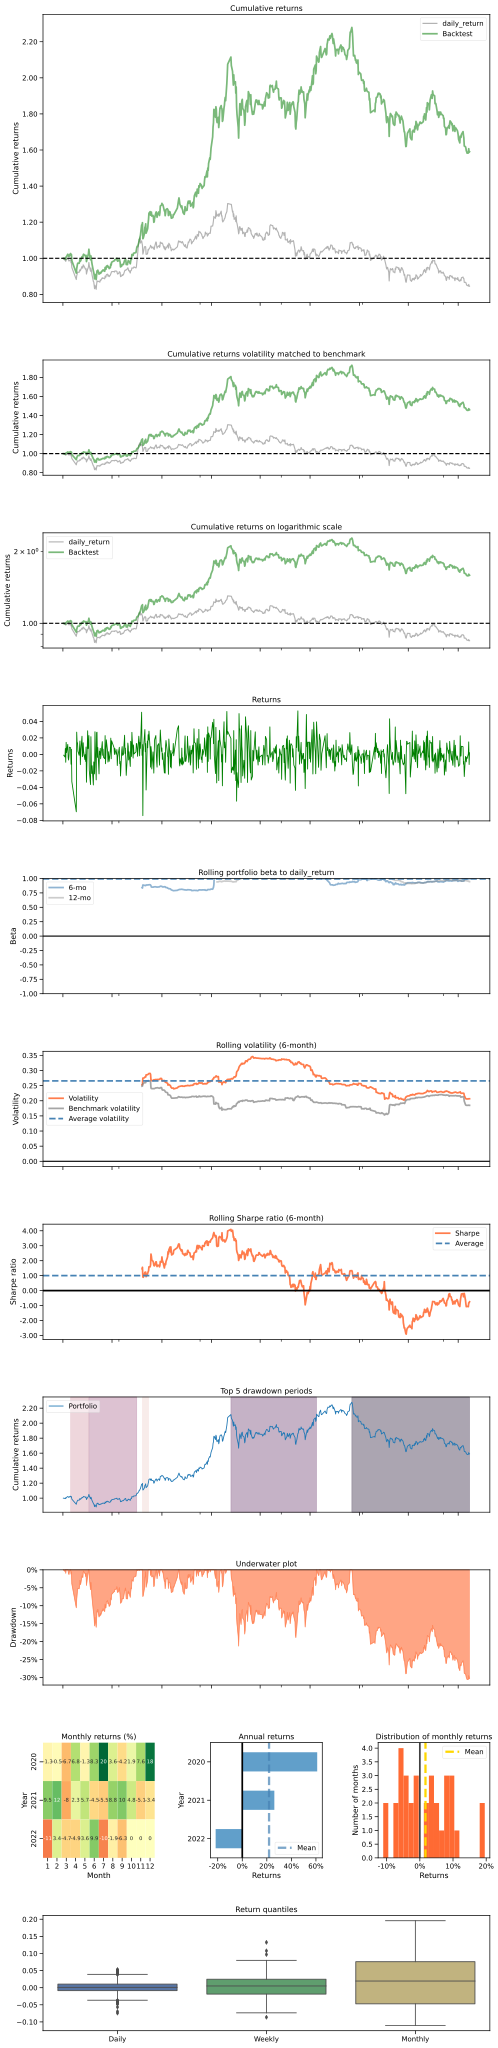

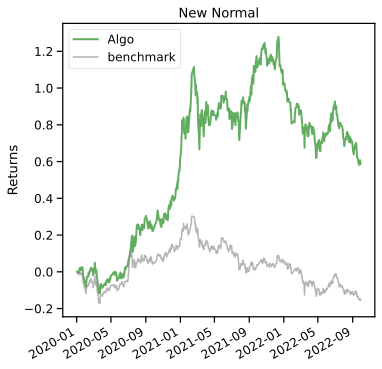

In [104]:
import pyfolio
from pyfolio import timeseries

%matplotlib inline

daily_return = get_daily_return(df_account_value)
daily_return_base = get_daily_return(baseline_df, value_col_name='close')

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)